<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-1/blob/main/FaceRecognitionBueno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descarga del dataset

In [ ]:
!wget https://www.dropbox.com/s/knkdotwfob09y2u/3.zip?dl=0 -O 3.zip
!unzip 3.zip

# Pruebas

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
!wget https://www.dropbox.com/s/uji1ufb009ic3m0/mobilenet_graph.pb?dl=0 -O mobilenet_graph.pb
# Leer mobilenet_graph.pb
with tf.io.gfile.GFile('mobilenet_graph.pb','rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Graph().as_default() as mobilenet:
    tf.import_graph_def(graph_def,name='')

--2021-05-18 14:31:09--  https://www.dropbox.com/s/uji1ufb009ic3m0/mobilenet_graph.pb?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uji1ufb009ic3m0/mobilenet_graph.pb [following]
--2021-05-18 14:31:09--  https://www.dropbox.com/s/raw/uji1ufb009ic3m0/mobilenet_graph.pb
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2c5a0d98226259ee10fbf212da.dl.dropboxusercontent.com/cd/0/inline/BOtYepvh5b7NS3jrXYOqoJNFY5ElcKRAtK2zOGqEOzFec5lnVqJ2i1rPcF80mtST0JRaHN5LxZnjVHUtV82b3XOrZEkKQwLWX_Dvr8hZ5Lk1N6JzxZZpHQnkIwV1QOfbVvgDfHvp5mTp_8zLvL0EVhk2/file# [following]
--2021-05-18 14:31:09--  https://uc2c5a0d98226259ee10fbf212da.dl.dropboxusercontent.com/cd/0/inline/BOtYepvh5b7NS3jrXYOqoJNFY5ElcKRAtK2zOGqEOzFec5lnVqJ2i1rPcF80mtST0JR

In [6]:
print(mobilenet)

In [7]:
# Cargar imagen
def load_image(DIR, NAME):
    return cv2.cvtColor(cv2.imread(f'{DIR}/{name}'), cv2.COLOR_BGR2RGB)

In [8]:
def detect_faces(image, score_threshold=0.7):
    global boxes, scores
    (imh, imw) = image.shape[:-1]
    img = np.expand_dims(image,axis=0)
    
    # Inicializar mobilenet
    sess = tf.compat.v1.Session(graph=mobilenet)
    image_tensor = mobilenet.get_tensor_by_name('image_tensor:0')
    boxes = mobilenet.get_tensor_by_name('detection_boxes:0')
    scores = mobilenet.get_tensor_by_name('detection_scores:0')
    
    # Predicción (detección)
    (boxes, scores) = sess.run([boxes, scores], feed_dict={image_tensor:img})
    
    # Reajustar tamaños boxes, scores
    boxes = np.squeeze(boxes,axis=0)
    scores = np.squeeze(scores,axis=0)
    
    # Depurar bounding boxes
    idx = np.where(scores>=score_threshold)[0]
    
    # Crear bounding boxes
    bboxes = []
    for index in idx:
        ymin, xmin, ymax, xmax = boxes[index,:]
        (left, right, top, bottom) = (xmin*imw, xmax*imw, ymin*imh, ymax*imh)
        left, right, top, bottom = int(left), int(right), int(top), int(bottom)
        bboxes.append([left,right,top,bottom])
        
    return bboxes

In [9]:
# Dibujar bounding boxes
def draw_box(image,box,color,line_width=6):
    if box==[]:
        return image
    else:
        cv2.rectangle(image,(box[0],box[2]),(box[1],box[3]),color,line_width)
    return image

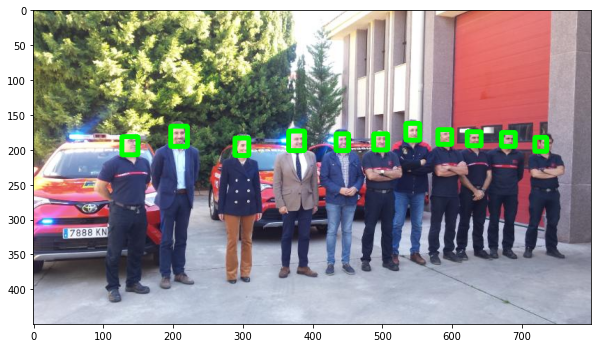

In [11]:
name = '777.jpg'
image = load_image('3',name)
bboxes = detect_faces(image)
for box in bboxes:
    detected_faces = draw_box(image,box,(0,255,0))
fig = plt.figure(figsize=(10,10))
plt.imshow(detected_faces)

In [12]:
# Extraer rostros
def extract_faces(image,bboxes,new_size=(160,160)):
    cropped_faces = []
    for box in bboxes:
        left, right, top, bottom = box
        face = image[top:bottom,left:right]
        cropped_faces.append(cv2.resize(face,dsize=new_size))
    return cropped_faces

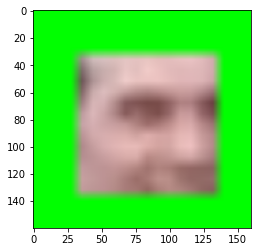

In [13]:
faces = extract_faces(image,bboxes)
plt.imshow(faces[1])

In [14]:
# FaceNet
!wget https://www.dropbox.com/s/z0o1of3580smtwr/facenet_keras.h5?dl=0 -O facenet_keras.h5


--2021-05-18 14:32:18--  https://www.dropbox.com/s/z0o1of3580smtwr/facenet_keras.h5?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/z0o1of3580smtwr/facenet_keras.h5 [following]
--2021-05-18 14:32:18--  https://www.dropbox.com/s/raw/z0o1of3580smtwr/facenet_keras.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc871b2698445eb92670389fb836.dl.dropboxusercontent.com/cd/0/inline/BOsjhI8eCUqeRjU_NscXI6CS15Xu27W4DOvUMkJGsrUAvyAh3szHSJ5my2px96VsoPt7xJY6sFOjJwU0DAHKXYf4WTUDcwq2ls1Qwtl53OaiyB5cVRfg2R1BZzZraBFfCkxTNSA-4u6_YkRYuSIMJVmw/file# [following]
--2021-05-18 14:32:18--  https://uc871b2698445eb92670389fb836.dl.dropboxusercontent.com/cd/0/inline/BOsjhI8eCUqeRjU_NscXI6CS15Xu27W4DOvUMkJGsrUAvyAh3szHSJ5my2px96VsoPt7xJY6s

In [15]:
facenet = load_model('facenet_keras.h5')

print(facenet.input_shape)
print(facenet.output_shape)

(None, 160, 160, 3)
(None, 128)


In [17]:
def compute_embedding(model,face):
    face = face.astype('float32')
    
    mean, std = face.mean(), face.std()
    face = (face-mean) / std
    
    face = np.expand_dims(face,axis=0)
    
    embedding = model.predict(face)
    return embedding

In [18]:
embedding = compute_embedding(facenet,faces[0])
print(embedding)

[[-5.82381934e-02 -1.19764686e+00  1.25598586e+00 -5.26612937e-01
  -2.20166907e-01 -4.10661191e-01  3.52265596e-01  7.58140087e-01
   6.79723799e-01 -1.51852882e+00  2.33484983e-01  5.75554743e-02
   2.27518654e+00  4.38606828e-01 -4.65667337e-01 -6.04926229e-01
  -1.79854333e-01  6.77351505e-02 -1.02673650e-01  5.66819049e-02
  -9.03088808e-01  8.01738977e-01 -1.69507933e+00  1.16097420e-01
   1.22030266e-04 -6.29971206e-01  3.65884095e-01  3.00557852e-01
  -8.46703112e-01  4.81536895e-01 -5.05037785e-01  6.28055573e-01
  -2.41421282e-01 -4.40057099e-01 -7.46894598e-01  1.33819151e+00
  -1.50288033e+00  3.95421863e-01 -1.06004906e+00  2.66634607e+00
   1.33339202e+00  2.90617913e-01  1.31665790e+00  4.82086301e-01
  -1.54306576e-01 -8.65637362e-01  7.94198692e-01 -1.83452129e-01
  -1.24661058e-01  3.11628431e-01 -1.84269404e+00  7.37763822e-01
  -1.73320770e-01 -1.45623744e-01 -7.57472217e-01  1.71476409e-01
  -9.73614812e-01 -7.92011797e-01  6.39628828e-01  8.22041929e-01
   9.11514

In [26]:
os.mkdir('foto')
os.mkdir('resultados')
!wget https://www.dropbox.com/s/jc493jeqq2wshuy/conchi.jpg?dl=0 -O conchi.jpg

--2021-05-18 14:35:31--  https://www.dropbox.com/s/jc493jeqq2wshuy/conchi.jpg?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jc493jeqq2wshuy/conchi.jpg [following]
--2021-05-18 14:35:31--  https://www.dropbox.com/s/raw/jc493jeqq2wshuy/conchi.jpg
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca4a95237249dfa30f59629e0e3.dl.dropboxusercontent.com/cd/0/inline/BOuL0DKYp4G5IRT9dEiZLBu02sWMbbJYYvKQizj6gkozAmaPbeFlrvCxSWgMEAqosubkTC-ZMb7uVuK7OVbz7dkVuj0ZP5Q7jliyJWzyOGUF0UnQPCHhG7scrg9KdnmPI4vzsG-6Yuyw178emoN2-MAo/file# [following]
--2021-05-18 14:35:31--  https://uca4a95237249dfa30f59629e0e3.dl.dropboxusercontent.com/cd/0/inline/BOuL0DKYp4G5IRT9dEiZLBu02sWMbbJYYvKQizj6gkozAmaPbeFlrvCxSWgMEAqosubkTC-ZMb7uVuK7OVbz7dkVuj0

In [23]:
# Embeddings referencia
known_embeddings = []

print('Procesando rostros conocidos...')
for name in os.listdir('foto'):
    if name.endswith('.jpg'):
        print(f'   {name}')
        image = load_image('foto',name)
        bboxes = detect_faces(image)
        face = extract_faces(image,bboxes)
        known_embeddings.append(compute_embedding(facenet,face[0]))        
        
        
        

Procesando rostros conocidos...


In [ ]:
print(known_embeddings)

[array([[-1.1265808 ,  0.38905317,  1.4481726 , -0.46339557,  0.5553209 ,
        -0.8921507 , -0.04404853,  1.2484659 , -0.11019192,  0.5265028 ,
         0.19791096,  0.2030252 ,  1.8285444 ,  0.03258635,  0.27863201,
        -0.790859  ,  0.46869057, -1.0388877 ,  0.80730665,  0.2729399 ,
        -0.5143863 , -0.7292056 , -0.15083465,  2.1143208 , -0.7895684 ,
         0.47113326, -0.25612754,  2.6408    ,  1.1033189 ,  0.3987583 ,
        -0.61350906, -0.5091016 ,  0.33928284, -0.18517645, -0.71768236,
        -0.24244514, -0.50024515,  0.44122046, -0.55662614,  0.3952867 ,
         1.020275  ,  0.82924944, -0.3578554 ,  0.75251013, -1.953096  ,
         0.9845971 , -0.3963197 , -1.258764  ,  0.20952608, -0.03790988,
         2.0361829 ,  2.3847454 , -0.1682815 , -2.4165993 , -0.24701223,
         1.2039596 , -0.43561643, -0.26044944,  0.17719579,  0.44411942,
         1.2490565 , -0.6665097 ,  1.0627357 ,  0.5034711 , -1.1275222 ,
        -0.33814567, -0.84260243,  0.3276574 ,  2.

# Prueba con foto real

In [24]:
def compare_faces(embs_ref, emb_desc, umbral=11):
    distancias = []
    for emb_ref in embs_ref:
        distancias.append(np.linalg.norm(emb_ref-emb_desc))
    distancias = np.array(distancias)
    return distancias, list(distancias<=umbral)

In [30]:
# Reconocimiento (????) de rostros desconocidos
print('Procesando imágenes desconocidas...')
cont=5
for name in os.listdir('resultados'):
    if name.endswith('.jpg'):
        print(f'   {name}')
        try:
          image = load_image('resultados',name)
          bboxes = detect_faces(image)
          faces = extract_faces(image,bboxes)
          
          # Por cada rostro calcular embedding
          img_with_boxes = image.copy()
          for face, box in zip(faces,bboxes):
              emb = compute_embedding(facenet,face)
              
              _, reconocimiento = compare_faces(known_embeddings,emb)
              
              if any(reconocimiento):
                  print('     match!')
                  img_with_boxes = draw_box(img_with_boxes,box,(0,255,0))
                  result='result'
                  if(cont<10):
                    cv2.imwrite(f'{result}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
                    cont=cont+1
              else:
                  img_with_boxes = draw_box(img_with_boxes,box,(255,0,0))
              resultados='resultados'
          ##cv2.imwrite(f'{resultados}/{name}',cv2.cvtColor(img_with_boxes,cv2.COLOR_RGB2BGR))
        except:
          print("An exception occurred")
print('¡Fin!')                    
            
        
        
        

Procesando imágenes desconocidas...
¡Fin!


# Almacenamiento de embedings

In [ ]:
print('Procesando imágenes')
data=[["NombreFoto", "Embedding"]]
for name in os.listdir('resultados'):
    if name.endswith('.jpg'):
        print(f'   {name}')
        try:
          image = load_image('resultados',name)
          bboxes = detect_faces(image)
          faces = extract_faces(image,bboxes)

          # Por cada rostro calcular embedding
          img_with_boxes = image.copy()
          cont=0
          for face, box in zip(faces,bboxes):
            lis=[]
            emb = compute_embedding(facenet,face)
            nameAux=name+" "+str(cont)
            lis.append(nameAux)
            lis.append(emb)
            data.append(lis)
            cont=cont+1

        except:
            print("An exception occurred")


Procesando imágenes
   0.jpg
   17.jpg
   10.jpg
   19.jpg
   6.jpg
   18.jpg
   5.jpg
   2.jpg
   4.jpg
   1.jpg
   7.jpg
   11.jpg
   8.jpg
   16.jpg
   descarga (3).jpg
   9.jpg
   12.jpg
   3.jpg
   14.jpg
   15.jpg
   13.jpg


In [ ]:
import csv
myFile = open('example.csv', 'w')
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(data)
     
print("Writing complete")

Writing complete


## Almacenamiento de Embeddings Completo

In [38]:
os.listdir('3')[20]

'1306.jpg'

In [ ]:
print('Procesando imágenes')
data=[["NombreFoto", "Embedding"]]
#len(os.listdir('3'))
for name in range(0,1000):
    if os.listdir('3')[name].endswith('.jpg'):
        print(f'   {name}')
        # try:
        if 1==1:
          image = cv2.imread('3/'+str(os.listdir('3')[name]), cv2.COLOR_BGR2RGB)
          bboxes = detect_faces(image)
          faces = extract_faces(image,bboxes)

          # Por cada rostro calcular embedding
          cont=0
          for face, box in zip(faces,bboxes):
            lis=[]
            emb = compute_embedding(facenet,face)
            nameAux=str(os.listdir('3')[name])+" "+str(cont)
            lis.append(nameAux)
            lis.append(emb)
            data.append(lis)
            cont=cont+1

        # except:
        #     print("An exception occurred")

import csv
myFile = open('example2.csv', 'w')
with myFile:
    writer = csv.writer(myFile)
    writer.writerows(data)
     
print("Writing complete")

Procesando imágenes
   0
   1
   2
   3
   4
   5
   6
   7
   8
   9
   10
   11
   12
   13
   14
   15
   16
   17
   18
   19
   20
   21
   22
   23
   24
   25
   26
   27
   28
   29
   30
   31
   32
   33
   34
   35
   36
   37
   38
   39
   40
   41
   42
   43
   44
   45
   46
   47
   48
   49
   50
   51
   52
